## Лабораторная работа № 2 
## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 2

В данной части работы рассмотрены:
* подготовка признаков для рашения задачи **градиентного бустинга** на деревьях решений;
* создание и обучение модели градиентного бустинга;
* оценка качества модели.

#### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, Binarizer, Bucketizer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import *


Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 2 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [5]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

25/04/11 20:09:20 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServ

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: org.apache.hadoop.hdfs.server.namenode.SafeModeException: Cannot create directory /user/user6/.sparkStaging/application_1744283300662_0002. Name node is in safe mode.
The reported blocks 0 needs additional 22191 blocks to reach the threshold 0.9990 of total blocks 22214.
The minimum number of live datanodes is not required. Safe mode will be turned off automatically once the thresholds have been reached. NamenodeHostName:node32.cluster
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.newSafemodeException(FSNamesystem.java:1661)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.checkNameNodeSafeMode(FSNamesystem.java:1648)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.mkdirs(FSNamesystem.java:3530)
	at org.apache.hadoop.hdfs.server.namenode.NameNodeRpcServer.mkdirs(NameNodeRpcServer.java:1173)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolServerSideTranslatorPB.mkdirs(ClientNamenodeProtocolServerSideTranslatorPB.java:750)
	at org.apache.hadoop.hdfs.protocol.proto.ClientNamenodeProtocolProtos$ClientNamenodeProtocol$2.callBlockingMethod(ClientNamenodeProtocolProtos.java)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine2.java:621)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine2.java:589)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine2.java:573)
	at org.apache.hadoop.ipc.RPC$Server.call(RPC.java:1227)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:1246)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:1169)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.security.auth.Subject.doAs(Subject.java:422)
	at org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1953)
	at org.apache.hadoop.ipc.Server$Handler.run(Server.java:3203)

	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.hadoop.ipc.RemoteException.instantiateException(RemoteException.java:121)
	at org.apache.hadoop.ipc.RemoteException.unwrapRemoteException(RemoteException.java:88)
	at org.apache.hadoop.hdfs.DFSClient.primitiveMkdir(DFSClient.java:2509)
	at org.apache.hadoop.hdfs.DFSClient.mkdirs(DFSClient.java:2483)
	at org.apache.hadoop.hdfs.DistributedFileSystem$27.doCall(DistributedFileSystem.java:1485)
	at org.apache.hadoop.hdfs.DistributedFileSystem$27.doCall(DistributedFileSystem.java:1482)
	at org.apache.hadoop.fs.FileSystemLinkResolver.resolve(FileSystemLinkResolver.java:81)
	at org.apache.hadoop.hdfs.DistributedFileSystem.mkdirsInternal(DistributedFileSystem.java:1499)
	at org.apache.hadoop.hdfs.DistributedFileSystem.mkdirs(DistributedFileSystem.java:1474)
	at org.apache.hadoop.fs.FileSystem.mkdirs(FileSystem.java:2388)
	at org.apache.hadoop.fs.FileSystem.mkdirs(FileSystem.java:750)
	at org.apache.spark.deploy.yarn.Client.prepareLocalResources(Client.scala:486)
	at org.apache.spark.deploy.yarn.Client.createContainerLaunchContext(Client.scala:962)
	at org.apache.spark.deploy.yarn.Client.submitApplication(Client.scala:215)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.start(YarnClientSchedulerBackend.scala:62)
	at org.apache.spark.scheduler.TaskSchedulerImpl.start(TaskSchedulerImpl.scala:235)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:599)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.hdfs.server.namenode.SafeModeException): Cannot create directory /user/user6/.sparkStaging/application_1744283300662_0002. Name node is in safe mode.
The reported blocks 0 needs additional 22191 blocks to reach the threshold 0.9990 of total blocks 22214.
The minimum number of live datanodes is not required. Safe mode will be turned off automatically once the thresholds have been reached. NamenodeHostName:node32.cluster
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.newSafemodeException(FSNamesystem.java:1661)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.checkNameNodeSafeMode(FSNamesystem.java:1648)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.mkdirs(FSNamesystem.java:3530)
	at org.apache.hadoop.hdfs.server.namenode.NameNodeRpcServer.mkdirs(NameNodeRpcServer.java:1173)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolServerSideTranslatorPB.mkdirs(ClientNamenodeProtocolServerSideTranslatorPB.java:750)
	at org.apache.hadoop.hdfs.protocol.proto.ClientNamenodeProtocolProtos$ClientNamenodeProtocol$2.callBlockingMethod(ClientNamenodeProtocolProtos.java)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine2.java:621)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine2.java:589)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine2.java:573)
	at org.apache.hadoop.ipc.RPC$Server.call(RPC.java:1227)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:1246)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:1169)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.security.auth.Subject.doAs(Subject.java:422)
	at org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1953)
	at org.apache.hadoop.ipc.Server$Handler.run(Server.java:3203)

	at org.apache.hadoop.ipc.Client.getRpcResponse(Client.java:1612)
	at org.apache.hadoop.ipc.Client.call(Client.java:1558)
	at org.apache.hadoop.ipc.Client.call(Client.java:1455)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Invoker.invoke(ProtobufRpcEngine2.java:242)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Invoker.invoke(ProtobufRpcEngine2.java:129)
	at com.sun.proxy.$Proxy33.mkdirs(Unknown Source)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolTranslatorPB.mkdirs(ClientNamenodeProtocolTranslatorPB.java:674)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invokeMethod(RetryInvocationHandler.java:422)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeMethod(RetryInvocationHandler.java:165)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invoke(RetryInvocationHandler.java:157)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeOnce(RetryInvocationHandler.java:95)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:359)
	at com.sun.proxy.$Proxy34.mkdirs(Unknown Source)
	at org.apache.hadoop.hdfs.DFSClient.primitiveMkdir(DFSClient.java:2507)
	... 27 more


#### Загрузка датасета

Укажем базу данных, которая была создана в первой лабораторной работе.

In [15]:
database_name = "Efremenkov_database"

Установим созданную базу данных как текущую.

In [16]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем таблицу с **предобработанным датасетом** и загрузим её в `Spark Dataframe`.

In [17]:
df = spark.table("sobd_lab1_processed_table")

Выведем прочитанную таблицу на экран.

In [18]:
df.show()

+--------------------+--------------------+-------------------------+-------------+---------------+--------------------+----------------------+------------------+----------------------+-------------------+
|             LMK_KEY|             ADDRESS|CURRENT_ENERGY_EFFICIENCY|PROPERTY_TYPE|INSPECTION_DATE|HEATING_COST_CURRENT|HOT_WATER_COST_CURRENT|  TOTAL_FLOOR_AREA|NUMBER_HABITABLE_ROOMS|NUMBER_HEATED_ROOMS|
+--------------------+--------------------+-------------------------+-------------+---------------+--------------------+----------------------+------------------+----------------------+-------------------+
|0003352408dad177e...|21 HERIOT GRANGE,...|                       53|         Flat|     2021-08-03|               119.0|                 583.0|              36.0|                   2.0|                2.0|
|15149389392220170...| 9, Sea View Terrace|                       66|        House|     2017-01-26|               666.0|                 107.0|              88.0|              

Вспомним описание столбцов и параметры датасета, проанализированные в первой лабораторной работе.

| Название столбца          | Расшифровка |  Тип признака и его характеристики
| ------------------------- | ------------- | ------------------ |
| LMK_KEY                   | Первичный ключ |  |
| ADDRESS                   | Адрес  |  |
| CURRENT_ENERGY_EFFICIENCY | Эффективность энергии | Количественный |
| PROPERTY_TYPE             | Тип квартиры | Категориальный |
| INSPECTION_DATE           | Дата инспекции |  |
| HEATING_COST_CURRENT      | Затраты на обогрев | количественный |
| HOT_WATER_COST_CURRENT    | Затраты на горячую воду | количественный |
| TOTAL_FLOOR_AREA          | Площадь | Количественный |
| NUMBER_HABITABLE_ROOMS    | Количество обитаемых комнат | Количественный |
| NUMBER_HEATED_ROOMS       | Количество комнат с подогревом | Количественный |

Вспомним схему данных.

In [19]:
df.printSchema()

root
 |-- LMK_KEY: string (nullable = true)
 |-- ADDRESS: string (nullable = true)
 |-- CURRENT_ENERGY_EFFICIENCY: integer (nullable = true)
 |-- PROPERTY_TYPE: string (nullable = true)
 |-- INSPECTION_DATE: date (nullable = true)
 |-- HEATING_COST_CURRENT: float (nullable = true)
 |-- HOT_WATER_COST_CURRENT: float (nullable = true)
 |-- TOTAL_FLOOR_AREA: double (nullable = true)
 |-- NUMBER_HABITABLE_ROOMS: float (nullable = true)
 |-- NUMBER_HEATED_ROOMS: float (nullable = true)



Вычислим количество строк в датафрейме.

In [20]:
df.count()

2996861

#### Постановка задачи

Для датасета, заданного представленными колонками, требуется построить модель **градиентного бустинга на деревьях решений** для оценки факта того, что комфортность квартиры определяется по всем остальным признакам. (Если AUC-ROC больше 85, то проживание считается комфортным)

Для оценки качества обучения следует использовать метрики `Precision` и `Recall`. Оценить максимально возможное значение **точности** при полноте не менее 60%.

In [23]:
def valueToCategory(value):
   if   value >= 85: return 1.0
   else: return 0.0

#### Подготовка и кодирование признаков

Для корректной работы трансформеров преобразуем столбцы `HEATING_COST_CURRENT`, `HOT_WATER_COST_CURRENT`, `NUMBER_HABITABLE_ROOMS`, `NUMBER_HEATED_ROOMS` к типу `DoubleType`, а столбец `TOTAL_FLOOR_AREA` сделаем бинаризируемым с преобразованием в `Double`

In [21]:
df = df.withColumn("HEATING_COST_CURRENT", F.col("HEATING_COST_CURRENT").cast(DoubleType()))
df = df.withColumn("HOT_WATER_COST_CURRENT", F.col("HOT_WATER_COST_CURRENT").cast(DoubleType()))
df = df.withColumn("NUMBER_HABITABLE_ROOMS", F.col("NUMBER_HABITABLE_ROOMS").cast(DoubleType()))
df = df.withColumn("NUMBER_HEATED_ROOMS", F.col("NUMBER_HEATED_ROOMS").cast(DoubleType()))

Бинаризируем столбец TOTAL_FLOOR_AREA. Выполняется 1 раз

In [24]:
udfValueToCategory = udf(valueToCategory, DoubleType())
df = df.withColumn("TOTAL_FLOOR_AREA", udfValueToCategory("TOTAL_FLOOR_AREA") )

In [25]:
df.show()

+--------------------+--------------------+-------------------------+-------------+---------------+--------------------+----------------------+----------------+----------------------+-------------------+
|             LMK_KEY|             ADDRESS|CURRENT_ENERGY_EFFICIENCY|PROPERTY_TYPE|INSPECTION_DATE|HEATING_COST_CURRENT|HOT_WATER_COST_CURRENT|TOTAL_FLOOR_AREA|NUMBER_HABITABLE_ROOMS|NUMBER_HEATED_ROOMS|
+--------------------+--------------------+-------------------------+-------------+---------------+--------------------+----------------------+----------------+----------------------+-------------------+
|0003352408dad177e...|21 HERIOT GRANGE,...|                       53|         Flat|     2021-08-03|               119.0|                 583.0|             0.0|                   2.0|                2.0|
|15149389392220170...| 9, Sea View Terrace|                       66|        House|     2017-01-26|               666.0|                 107.0|             1.0|                   5.0| 

Выполним **стратифицированное** разделение датасета на обучающую и тестовую выборки.

In [26]:
def stratified_train_test_split(data: DataFrame, 
                                label_col: str,
                                ratio: float) -> tuple[DataFrame, DataFrame]:
    """
    Разделяет DataFrame на тренировочный и тестовый наборы с учетом стратификации.

    Args:
        data: Исходный DataFrame.
        label_col: Название столбца с меткой.
        ratio: Пропорция разделения данных.

    Returns:
        tuple[DataFrame, DataFrame]: Кортеж из тренировочного и тестового DataFrame.
    """
    # Проверяем корректность доли разделения
    assert (isinstance(ratio, float) and (0.0 <= ratio <= 1.0))
    
    # Формируем разделение для положительных и отрицательных объектов раздельно
    train_df_pos, test_df_pos = (data
                                 .filter(F.col(label_col) == 1)
                                 .randomSplit([ratio, 1 - ratio]))
    train_df_neg, test_df_neg = (data
                                 .filter(F.col(label_col) == 0)
                                 .randomSplit([ratio, 1 - ratio]))
    
    # Объединяем датафреймы
    return (train_df_pos.union(train_df_neg),
            test_df_pos.union(test_df_neg))

In [27]:
train_df, test_df = stratified_train_test_split(df, "TOTAL_FLOOR_AREA", 0.8)

Закешируем сформированные датафреймы и проверим их объем.

In [28]:
train_df = train_df.cache()
test_df = test_df.cache()

print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 2398463


Test  dataset size: 598398


Как мы уже знаем из анализа датасета, если целевой переменной является `TOTAL_FLOOR_AREA`, то датасет является **несбалансированным**.

In [29]:
train_df.groupBy("TOTAL_FLOOR_AREA").count().show()

+----------------+-------+
|TOTAL_FLOOR_AREA|  count|
+----------------+-------+
|             1.0| 918576|
|             0.0|1479887|
+----------------+-------+



Выполним балансировку датасета с помощью `oversampling` - подбирает одинаковое количество 1 и 0. 

In [30]:
def oversample(data: DataFrame, column: str) -> DataFrame:
    """
    Выполняет oversampling положительных классов в DataFrame.

    Args:
        data: Исходный DataFrame.
        column: Название столбца с меткой.

    Returns:
        DataFrame: Датафрейм с выполненным oversampling.
    """
    # Разделим датафрейм на положительные и отрицательные классы
    pos = data.filter(F.col(column) == 1.0)
    neg = data.filter(F.col(column) == 0.0)

    # Получим количество записей в каждом классе
    total_pos = pos.count()
    total_neg = neg.count()
    
    print(total_pos)
    print(total_neg)

    # Если количество положительных классов меньше отрицательных,
    # выполним oversampling
    if total_pos < total_neg:
        # Вычислим количество необходимых дубликатов
        num_duplicates = total_neg - total_pos
        print(num_duplicates)
        # Дублируем положительные записи
        oversampled_pos = pos.withColumn(
            "dummy",
            F.explode(
                F.array_repeat(F.lit(1),
                               num_duplicates // total_pos + 1)
            )
        ).drop("dummy")
        print(num_duplicates // total_pos + 1)
        # Объединим дублированные положительные записи с отрицательными
        balanced_df = neg.union(oversampled_pos)
    else:
        balanced_df = data

    return balanced_df

In [31]:
train_df = oversample(train_df, column="TOTAL_FLOOR_AREA")

918576
1479887
561311
1


Проверим баланс классов в получившемся датасете.

In [32]:
train_df.groupBy("TOTAL_FLOOR_AREA").count().show()

+----------------+-------+
|TOTAL_FLOOR_AREA|  count|
+----------------+-------+
|             0.0|1479887|
|             1.0|1479887|
+----------------+-------+



Понятно, что **ключ и адрес** квартиры не оказывает влияния на тип недвижимости. Использовать его в модели нет смысла.

Остальные признаки сгруппируем по их типу:

* **Категориальные** признаки не содержат большого количества категорий, закодируем их `one-hot`-кодировкой.
* **Бинарные** признаки представлены значениями `true` / `false`, которые могут быть интерпретированы как единица и нуль. Поэтому, в кодировании не нуждаются.
* **Количественные** признаки нужно нормализовать / стандартизировать, перед тем, как передавать их в модель.

In [33]:
categorical_features = [ "PROPERTY_TYPE" ]
numeric_features = [
    "CURRENT_ENERGY_EFFICIENCY", "HEATING_COST_CURRENT", "HOT_WATER_COST_CURRENT", "NUMBER_HABITABLE_ROOMS", "NUMBER_HEATED_ROOMS"
]

Создадим конвейер обработки данных, включающий модель градиентного бустинга на деревьях решений.

In [34]:
def create_pipeline(categorical_features: list[str], 
                    numeric_features: list[str], 
                    #binary_features: list[str], binarized_col: str, threshold: float, 
                    label_col: str, 
                    max_iter: int) -> Pipeline:
    """
    Создает конвейер для обработки данных и обучения модели градиентного бустинга.

    Args:
        categorical_features: Список категориальных признаков.
        numeric_features: Список количественных признаков.
        label_col: Название столбца с меткой.
        max_iter: Максимальное количество итераций для модели.

    Returns:
        Pipeline: Конвейер для обработки данных и обучения модели.
    """
    # Формируем названия колонок для преобразованных признаков
    indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    
    # Выполняем преобразования данных
    string_indexer = StringIndexer(inputCols=categorical_features,
                                   outputCols=indexed_categorical_features,
                                   handleInvalid="keep")
    vector_all_assembler = VectorAssembler(
        inputCols=(indexed_categorical_features + #binary_features +
                   numeric_features),
        outputCol="features"
    )

    # Создаем модель линейной регрессии
    gbt_classifier = GBTClassifier(featuresCol="features",
                                   labelCol=label_col,
                                   predictionCol="prediction",
                                   maxIter=max_iter)

    # Создаем конвейер
    pipeline = Pipeline(stages=[
        string_indexer, 
        vector_all_assembler, 
        gbt_classifier
    ])

    return pipeline

In [35]:
pipeline = create_pipeline(categorical_features=categorical_features,
                           numeric_features=numeric_features,
                           label_col="TOTAL_FLOOR_AREA",
                           max_iter=30)

#### Обучение модели

Выполним **подбор гиперпараметров** модели линейной регрессии с помощью кросс-валидации на сетке.

Создаем сетку параметров для кросс-валидации, получив объект `GBTClassifier` из конвейера.

In [36]:
# param_grid = ParamGridBuilder() \
#     .addGrid(pipeline.getStages()[-1].maxDepth, [3, 5, 7]) \
#     .addGrid(pipeline.getStages()[-1].stepSize, [0.1, 0.01, 0.001]) \
#     .build()

# Подбор гиперпараметров, указанный выше, выполняется на кластере несколько часов :))
# Для ознакомления можно использовать упрощенную процедуру, приведенную ниже
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].maxDepth, [5]) \
    .addGrid(pipeline.getStages()[-1].stepSize, [0.01]) \
    .build()

Создаем экземпляр `BinaryClassificationEvaluator` для оценки модели.

In [37]:
cv_evaluator = BinaryClassificationEvaluator(labelCol="TOTAL_FLOOR_AREA")

Создаем объект `CrossValidator`.

In [38]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=5)

Обучаем модель конвейера с использованием кросс-валидации.

In [39]:
cv_model = cross_validator.fit(train_df)

In [40]:
student_hdfs_folder = "Efremenkov_directory"
# Получаем имя пользователя
user_name = os.getenv("USER")

# Путь модели в HDFS
model_hdfs_path = f"hdfs:///user/{user_name}/{student_hdfs_folder}/models/GBT-model"

# Сохраняем модель конвейера в HDFS
try:
    cv_model.bestModel.save(model_hdfs_path)
    print(f"Модель успешно сохранена в \"{model_hdfs_path}\"")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

25/03/10 11:47:32 ERROR Instrumentation: java.io.IOException: Path hdfs:///user/user6/Efremenkov_directory/models/GBT-model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun

Ошибка при сохранении модели: An error occurred while calling o3591.save.
: java.io.IOException: Path hdfs:///user/user6/Efremenkov_directory/models/GBT-model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.Pipelin

Выведем параметры **лучшей** модели, определенной в ходе кросс-валидации.

In [41]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model: Объект CrossValidatorModel, содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    best_params = {
        "maxDepth": best_model.stages[-1].getMaxDepth(),
        "stepSize": best_model.stages[-1].getStepSize(),
        "maxIter": best_model.stages[-1].getMaxIter()
    }
    return best_params

In [42]:
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

maxDepth: 5
stepSize: 0.01
maxIter: 30


#### Анализ обученной модели

Рассчитаем метрики на тестовом датасете.

In [43]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("TOTAL_FLOOR_AREA")
right_columns_order.append("TOTAL_FLOOR_AREA")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.show()

+--------------------+--------------------+-------------------------+-------------+---------------+--------------------+----------------------+----------------------+-------------------+-------------------+--------------------+--------------------+--------------------+----------+----------------+
|             LMK_KEY|             ADDRESS|CURRENT_ENERGY_EFFICIENCY|PROPERTY_TYPE|INSPECTION_DATE|HEATING_COST_CURRENT|HOT_WATER_COST_CURRENT|NUMBER_HABITABLE_ROOMS|NUMBER_HEATED_ROOMS|PROPERTY_TYPE_index|            features|       rawPrediction|         probability|prediction|TOTAL_FLOOR_AREA|
+--------------------+--------------------+-------------------------+-------------+---------------+--------------------+----------------------+----------------------+-------------------+-------------------+--------------------+--------------------+--------------------+----------+----------------+
|0000717fe59fa33d5...|   21 Kirkstone Road|                       65|        House|     2023-01-16|       

In [44]:
def evaluate_model(data: DataFrame, 
                   label_col: str) -> dict[str, float]:
    """
    Оценивает модель с использованием метрик точности, полноты и F1-score.

    Args:
        data: DataFrame, содержащий предсказания и фактические метки.
        label_col: Название колонки с меткой.

    Returns:
        dict[str, float]: Словарь с метриками точности, полноты и F1-score.
    """
    # Вычисляем TP, FP, FN
    tp = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 1)).count()
    fp = data.filter((F.col(label_col) == 0) &
                     (F.col("prediction") == 1)).count()
    fn = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 0)).count()

    # Вычисляем метрики
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0 else 0)

    # Возвращаем словарь с метриками
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [45]:
metrics = evaluate_model(test_df_predictions, "TOTAL_FLOOR_AREA")
print(f"Metrics: {metrics}")

Metrics: {'precision': 0.859179580674567, 'recall': 0.7177807853154796, 'f1': 0.7821408926234328}


Наблюдаем довольно низкую точность при высокой полноте. Попробуем подобрать `threshold`, чтобы максимизировать точность, но при этом удерживать полноту на заданном в постановке задачи уровне.
Сначала рассчитаем `AUC ROC`, визуализируем `ROC` и `PR`-кривые и оценим ситуацию.

In [46]:
def calculate_auc_roc(model: GBTClassificationModel, 
                      test_data: DataFrame,
                      label_col: str) -> float:
    """
    Рассчитывает значение AUC ROC для модели.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        float: Значение AUC ROC.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Создаем "оценщик" бинарной классификации
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="rawPrediction",
        labelCol=label_col
    )

    # Вычисляем AUC ROC
    auc_roc = evaluator.evaluate(predictions)

    return auc_roc

In [47]:
def prepare_metrics_df(predictions: DataFrame, label_col: str) -> DataFrame:
    """
    Подготавливает DataFrame для расчета FPR, TPR и Precision.

    Args:
        predictions: DataFrame с прогнозами модели.
        label_col: Название столбца с меткой.

    Returns:
        DataFrame: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
    """
    # Формируем датафрейм, содержащий результат предсказания,
    # вероятность предсказания и метку
    metrics_df = (
        predictions
        .select(
            vector_to_array(
                F.col("probability")
            ).getItem(1).alias("probability"),
            
            F.col(label_col).alias("label"),
            F.col("prediction").cast("int").alias("prediction")
        )
    )

    # Сортируем датафрейм по значениям вероятности
    metrics_df = metrics_df.orderBy("probability")

    # Рассчитываем количество положительных и отрицательных классов
    pos_count = metrics_df.filter(metrics_df.label == 1).count()
    neg_count = metrics_df.filter(metrics_df.label == 0).count()

    # Рассчитываем значения FPR и TPR
    window = Window.partitionBy().orderBy(F.desc("probability"))
    metrics_df = (
        metrics_df
        .withColumn("FP_cum", 
                    F.sum(F.when(
                        F.col("label") == 0, 1
                    ).otherwise(0)).over(window))
        .withColumn("TP_cum", F.sum(F.col("label")).over(window))
        .withColumn("FPR", F.col("FP_cum") / neg_count)
        .withColumn("TPR", F.col("TP_cum") / pos_count)
        .withColumn("Precision", 
                    F.col("TP_cum") / (F.col("TP_cum") + F.col("FP_cum")))
    )

    return metrics_df

In [48]:
def bucketize_metrics_df(metrics_df: DataFrame, 
                         num_buckets: int = 1000) -> DataFrame:
    """
    Применяет Bucketizer к DataFrame для уменьшения объёма данных, 
    возвращаемых на драйвер.

    Args:
        metrics_df: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
        num_buckets: Количество бакетов.

    Returns:
        DataFrame: Бакетизированный Dataframe.
    """
    # Определяем границы бакетов
    bucketizer = Bucketizer(
        splits=list(np.linspace(0, 1, num_buckets + 1)),
        inputCol="probability",
        outputCol="bucket"
    )

    # Применяем Bucketizer
    metrics_df = bucketizer.setHandleInvalid("error").transform(metrics_df)

    # Формируем одну точку из каждого бакета
    metrics_df = metrics_df.groupBy("bucket").agg(
        F.avg(F.col("probability")).alias("probability"),
        F.avg(F.col("FPR")).alias("FPR"),
        F.avg(F.col("TPR")).alias("TPR"),
        F.avg(F.col("Precision")).alias("Precision")
    )

    return metrics_df

In [49]:
def calculate_metrics(model: GBTClassificationModel, 
                      test_data: DataFrame,
                      label_col: str) -> pd.DataFrame:
    """
    Рассчитывает значения FPR, TPR и Precision для построения ROC и PR-кривых.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        tuple[float, pd.DataFrame]: Кортеж из значения AUC ROC и DataFrame 
                                    со значениями FPR, TPR и Precision.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Подготавливаем DataFrame для расчета FPR, TPR и Precision
    metrics_df = prepare_metrics_df(predictions, label_col)

    # Применяем Bucketizer к DataFrame
    metrics_df = bucketize_metrics_df(metrics_df)

    return metrics_df.toPandas()

In [50]:
def plot_roc_pr_curves(pd_data: pd.DataFrame, 
                       auc_roc: float) -> None:
    """
    Визуализирует ROC и PR-кривые, добавляет на график AUC ROC.

    Args:
        pd_data: Pandas DataFrame, содержащий столбцы 
            "FPR", "TPR", "Precision".
        auc_roc: Значение AUC-ROC.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Построение ROC-кривой
    sns.lineplot(x="FPR", y="TPR", data=pd_data, ax=axes[0])
    sns.lineplot(x=[0, 1], y=[0, 1], 
                 color="gray", linestyle="--", ax=axes[0])
    axes[0].set_xlabel("False Positive Rate (FPR)")
    axes[0].set_ylabel("True Positive Rate (TPR)")
    axes[0].set_title("ROC Curve")
    axes[0].grid()

    # Добавляем значение AUC-ROC в правом нижнем углу графика
    axes[0].text(0.94, 0.06, f'AUC-ROC: {auc_roc:.2f}', 
                 transform=axes[0].transAxes,
                 fontsize=12, verticalalignment='bottom', 
                 horizontalalignment='right',
                 bbox=dict(facecolor='white', 
                           alpha=0.8), zorder=5)

    # Построение PR-кривой
    sns.lineplot(x="TPR", y="Precision", 
                 data=pd_data, ax=axes[1])
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("PR Curve")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

25/03/10 11:48:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/10 11:48:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/10 11:48:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/10 11:48:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/10 11:48:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/10 11:48:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/03/10 1

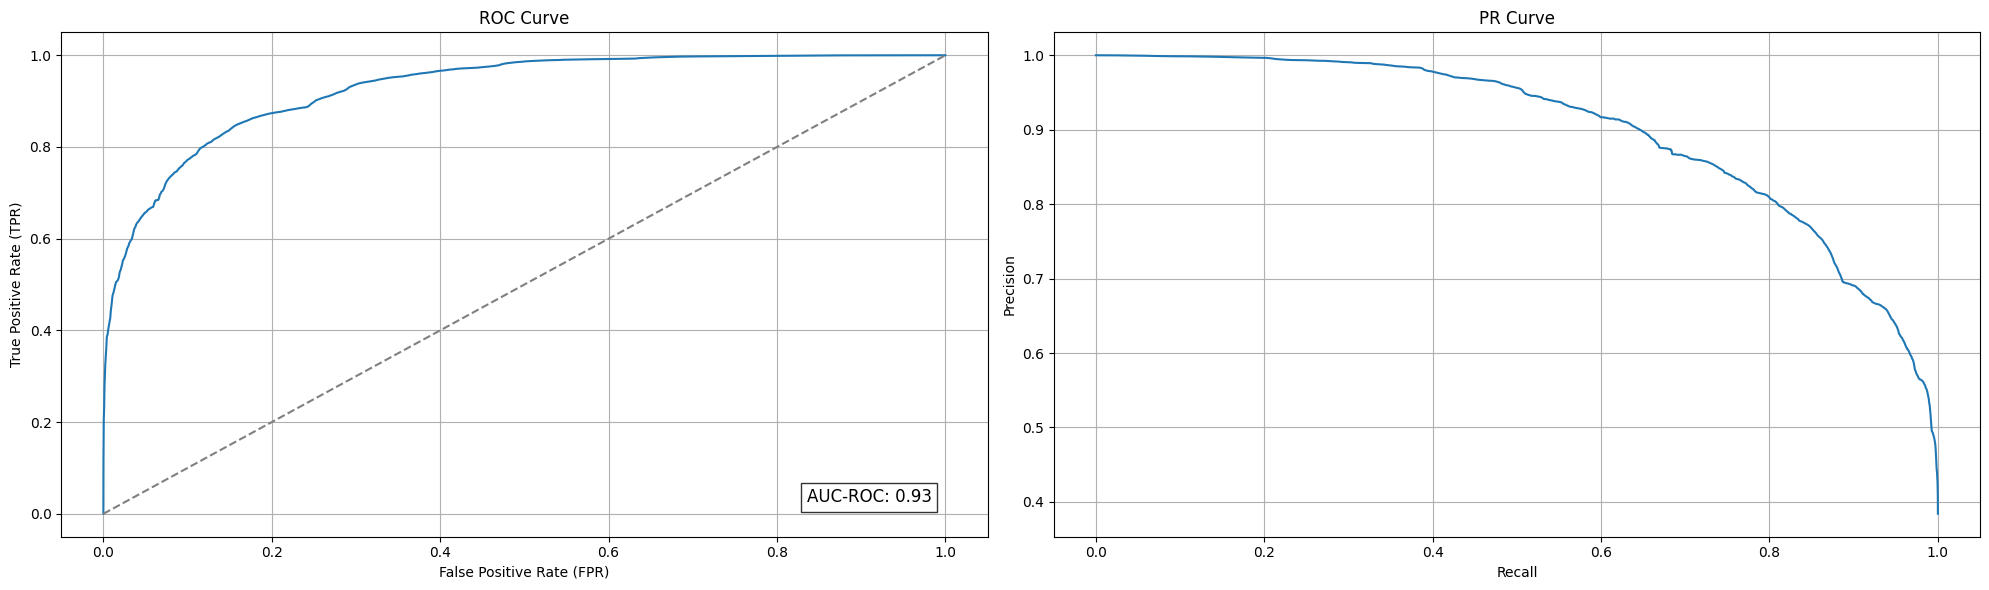

In [51]:
# Рассчитываем AUC ROC
auc_roc = calculate_auc_roc(model=cv_model,
                            test_data=test_df,
                            label_col="TOTAL_FLOOR_AREA")
pd_dataframe = calculate_metrics(model=cv_model,
                                 test_data=test_df,
                                 label_col="TOTAL_FLOOR_AREA")
plot_roc_pr_curves(pd_dataframe, auc_roc)

Определим вероятность -- границу разделения, при которой `Recall` не меньше 60%.

In [52]:
threshold_probability = pd_dataframe[pd_dataframe['TPR'] >= 0.60]['probability'].max()
print(f"Вероятность -- граница разделения, при которой TPR не меньше 60%: {threshold_probability:.2f}")

Вероятность -- граница разделения, при которой TPR не меньше 60%: 0.70


Рассчитаем метрики на тестовом датасете повторно, с учетом вычисленного `threshold` для вероятности.

In [53]:
cv_model.bestModel.stages[-1].setThresholds([1 - threshold_probability, 
                                             threshold_probability])
test_df_predictions = cv_model.transform(test_df)
metrics = evaluate_model(test_df_predictions, "TOTAL_FLOOR_AREA")
print(f"Metrics: {metrics}")

Metrics: {'precision': 0.9164163632014035, 'recall': 0.6001314226281914, 'f1': 0.7252923526797572}


Обученная модель обладает не очень хорошим качеством. Для дальнейшего улучшения качества предсказания можно подобрать другую модель, сформировать другие признаки, добавить к модели дополнительные данные и т.д.

Не забываем завершать `Spark`-сессию.

In [54]:
spark.stop()